In [24]:
import pandas as pd
import numpy as np
import json
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from sklearn.cluster import KMeans, MiniBatchKMeans
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn import metrics
import nltk
import gensim
import os
import string
import re
import os
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cluster import DBSCAN
from sklearn.externals import joblib
import csv
import tweepy
import cnfg


pd.set_option('display.max_colwidth', -1)
# pd.set_option('display.max_colwidth', 50)

In [2]:
from pandas import DataFrame
import json
from pymongo import MongoClient


client = MongoClient(port=12345)
db = client.stocks


df = DataFrame(list(db.stocks.find({})))

In [3]:
df['user'] = 'stock_whisperer'

In [4]:
list1 = []
for i in range(len(df['text'])):
    list1.append(df['text'].str.split(' http')[i][0])
    
se = pd.Series(list1)
se = se.str.replace('b"', "b'")
se = se.str.replace('$', "XX'")

In [5]:
list2 = []
for i in range(len(df['text'])):
    list2.append(se.str.split("b'")[i][1])

In [6]:
se2 = pd.Series(list2)
df['cleanedtext'] = se2.values

In [7]:
## If text contains stock of fortune 500

In [59]:
sandp100 = ['AAPL','ABBV','ABT','ACN','AGN','AIG','ALL','AMGN','AMZN','AXP','BA','BAC',
            'BIIB','BK','BLK','BMY','BRK.B','C','CAT','CELG','CL','CMCSA','COF','COP',
            'COST','CSCO','CVS','CVX','DD','DHR','DIS','DOW','DUK','EMR','EXC','F','FB',
            'FDX','FOX','FOXA','GD','GE','GILD','GM','GOOG','GOOGL','GS','HAL','HD','HON',
            'IBM','INTC','JNJ','JPM','KHC','KMI','KO','LLY','LMT','LOW','MA','MCD','MDLZ',
            'MDT','MET','MMM','MO','MON','MRK','MS','MSFT','NEE','NKE','ORCL','OXY','PCLN',
            'PEP','PFE','PG','PM','PYPL','QCOM','RTN','SBUX','SLB','SO','SPG','T','TGT',
            'TWX','TXN','UNH','UNP','UPS','USB','UTX','V','VZ','WBA','WFC','WMT','XOM']

sandp100lower = [element.lower() for element in sandp100]

In [454]:
# df22 = df[df['cleanedtext'].str.contains('$AAPL|ABBV|ABT|ACN|AGN|AIG|ALL|AMGN|AMZN|AXP|BA|BAC|BIIB|BK|BLK|BMY|BRK.B|C|CAT|CELG|CL|CMCSA|COF|COP|COST|CSCO|CVS|CVX|DD|DHR|DIS|DOW|DUK|EMR|EXC|F|FB|FDX|FOX|FOXA|GD|GE|GILD|GM|GOOG|GOOGL|GS|HAL|HD|HON|IBM|INTC|JNJ|JPM|KHC|KMI|KO|LLY|LMT|LOW|MA|MCD|MDLZ|MDT|MET|MMM|MO|MON|MRK|MS|MSFT|NEE|NKE|ORCL|OXY|PCLN|PEP|PFE|PG|PM|PYPL|QCOM|RTN|SBUX|SLB|SO|SPG|T|TGT|TWX|TXN|UNH|UNP|UPS|USB|UTX|V|VZ|WBA|WFC|WMT|XOM', na=False, case=True)]
# df22 = df[df['cleanedtext'].str.contains("XX'AAPL|XX'ABBV|XX'ABT|XX'ACN|XX'AGN|XX'AIG|XX'ALL|XX'AMGN|XX'AMZN|XX'AXP|XX'BA|XX'BAC|XX'BIIB|XX'BK|XX'BLK|XX'BMY|XX'BRK.B|XX'C|XX'CAT|XX'CELG|XX'CL|XX'CMCSA|XX'COF|XX'COP|XX'COST|XX'CSCO|XX'CVS|XX'CVX|XX'DD|XX'DHR|XX'DIS|XX'DOW|XX'DUK|XX'EMR|XX'EXC|XX'F|XX'FB|XX'FDX|XX'FOX|XX'FOXA|XX'GD|XX'GE|XX'GILD|XX'GM|XX'GOOG|XX'GOOGL|XX'GS|XX'HAL|XX'HD|XX'HON|XX'IBM|XX'INTC|XX'JNJ|XX'JPM|XX'KHC|XX'KMI|XX'KO|XX'LLY|XX'LMT|XX'LOW|XX'MA|XX'MCD|XX'MDLZ|XX'MDT|XX'MET|XX'MMM|XX'MO|XX'MON|XX'MRK|XX'MS|XX'MSFT|XX'NEE|XX'NKE|XX'ORCL|XX'OXY|XX'PCLN|XX'PEP|XX'PFE|XX'PG|XX'PM|XX'PYPL|XX'QCOM|XX'RTN|XX'SBUX|XX'SLB|XX'SO|XX'SPG|XX'T|XX'TGT|XX'TWX|XX'TXN|XX'UNH|XX'UNP|XX'UPS|XX'USB|XX'UTX|XX'V|XX'VZ|XX'WBA|XX'WFC|XX'WMT|XX'XOM", na=False, case=True)]

df22 = df[df['cleanedtext'].str.contains("Whisper",na=False, case=False)]
df22 = df22[df22['cleanedtext'].str.contains('yester|from|Wisconsin|email', case=False)==False]                                  

In [361]:
corpus = df22['cleanedtext']

In [362]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

totalvocab_stemmed = []
totalvocab_tokenized = []
for i in corpus:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
    
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 559 items in vocab_frame


In [363]:
stop = stopwords.words('english')
stoplistwords = ['gdx', 'today','whisperer', 'whisper', 'uso', 'fcx', 'aapl',
                 'ung', 'stock', 'day', 'aa', 'bac', 'mt','eem', 'xx','dark', 'pools','pool']
stop.extend(stoplistwords)
stop.extend(sandp100)
stop.extend(sandp100lower)


In [364]:
remove_nums = lambda x: re.sub(r"""\w*\d\w*""", ' ', x.lower())

tf = TfidfVectorizer(min_df=0.001, max_features=200000,
                     stop_words=stop, preprocessor=remove_nums,
                                 use_idf=True)

X2 = tf.fit_transform(corpus)

# bagofwords2 = pd.DataFrame(X2,
#              columns=tf.get_feature_names())

In [365]:
terms = tf.get_feature_names()
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(X2)

In [366]:
len(terms)

116

In [367]:
num_clusters = 4
km = KMeans(n_clusters=num_clusters)
%time km.fit(X2)
clusters = km.labels_.tolist()

kmlabels = km.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(kmlabels)) - (1 if -1 in kmlabels else 0)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X2, kmlabels))

CPU times: user 89.4 ms, sys: 3.13 ms, total: 92.5 ms
Wall time: 142 ms
Silhouette Coefficient: 0.081


In [368]:
df22['clusters'] = clusters
df22.set_index('clusters', inplace=True)
df22['clusters2'] = clusters

/Users/michaelcarrie/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/michaelcarrie/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [369]:
###KMEANS

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    temp_list = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        try:
            temp_list.append(terms[ind])
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        except:
            pass
    #the line below is for creating labels for the graph using the first threw words
    #cluster_names[i] = ', '.join(temp_list[:3])
    
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    try:
        for title in list(df22.ix[i]['cleanedtext'].values)[:30]:
            try:
                print(' %s,' % title, end='')
            except:
                pass
    except AttributeError:
        print(df22.ix[i]['cleanedtext'])
    
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:

Cluster 0 words: b'print', b'mil',

Cluster 0 titles: 1st Print of the day on XX'SPY 100K @ 208, 1st Print of the day on XX'SPY 1.7 mil 210.18, Commented on StockTwits: Dark pool print of the day 15 mil XX'VXX  XX'17.11 Contango vs backwardation 2morrow\xe2\x80\xa6, 1st Print of the day on XX'SPY 211.89 500K , ther will be more, stay tuned!, Today's #HOT #Whisper of the day XX'AA XX'NOK XX'GSK XX'SPY XX'UVXY , Commented on StockTwits: yes, middle of the day not a good time to enter, just did a quick +.17 on XX'DOW off the p..., Late Dark pool sell print of the day on the XX'SPY XX'197.70 millions and millions, bearish below, 1st XX'SPY print of the day XX'209.98 800K, 1st XX'SPY print of the day 700K 211.29,

Cluster 1 words: b'print', b'million', b'big', b'bearish',

Cluster 1 titles: 1st print of the day on XX'IWM 500K 128.66, 1st print of the day on XX'IWM 500K 121, bullish above, bearish below, BIG print alert XX'XOMA 1 million shares @4.07 , the low of the 

In [370]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# Random State is set seed in R
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [371]:
%matplotlib inline 
cluster_colors = {0: '#1b9e77', 1: '#d95f02',2: '#7570b3',
                  3: '#e7298a', 4: '#66a61e', 5: '#25a61e', 6: '#93a61e', 7: '#349a62'}

cluster_names = {0: 'random 3 topics', 
                 1: 'topic, blah, blah',          
                 2: 'Father, New York, brothers', 
                 3: 'random, blah, love',
                 4: 'what, blah, captain',
                 5: 'Blah, blah blah',
                 6: 'This is the 7th',
                7: 'This is the 8th'}

In [372]:
dfpt2 = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=df22.cleanedtext))
groups = dfpt2.groupby('label')

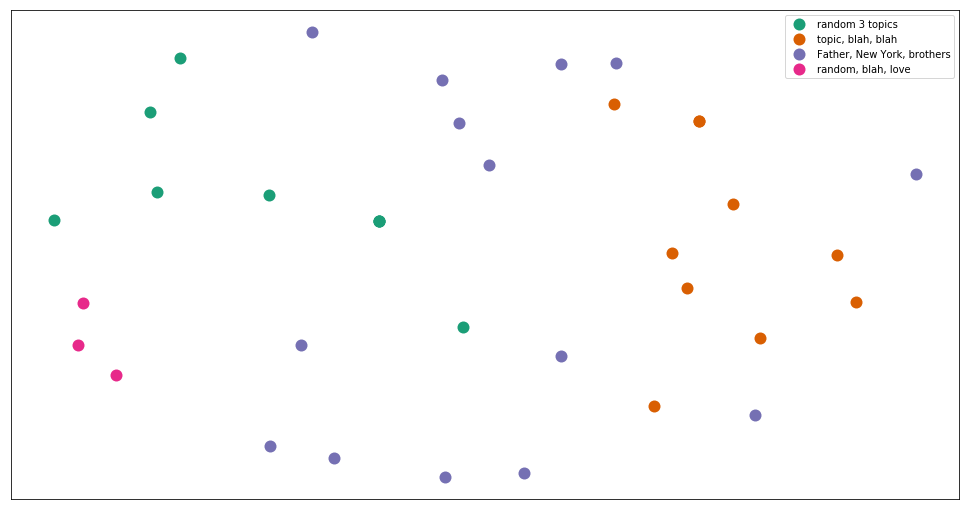

In [427]:
# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
# for i in range(len(dfpt2)):
#     ax.text(dfpt2.ix[i]['x'], dfpt2.ix[i]['y'], dfpt2.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [374]:
import quandl
mydata = quandl.get("WIKI/AAPL", start_date="2001-12-31", end_date="2005-12-31")

In [375]:
mydata.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2005-12-23,74.17,74.26,73.30,73.35,8209200.0,0.0,1.0,9.570554,9.582167,9.458293,9.464745,57464400.0
2005-12-27,74.00,75.18,73.95,74.23,21092500.0,0.0,1.0,9.548618,9.700880,9.542166,9.578296,147647500.0
2005-12-28,74.44,74.76,73.32,73.57,14218400.0,0.0,1.0,9.605393,9.646685,9.460874,9.493133,99528800.0
2005-12-29,73.78,73.82,71.42,71.45,17500900.0,0.0,1.0,9.520230,9.525391,9.215707,9.219578,122506300.0
2005-12-30,70.91,72.43,70.34,71.89,22295100.0,0.0,1.0,9.149899,9.346032,9.076348,9.276353,156065700.0


In [376]:
df22.head(1)

,_id,created_at,id,text,user,cleanedtext,clusters2
clusters,,,,,,,
0,5936b6abea2a7c07db002c1c,2015-07-02 12:04:22,616578155977912320,b'1st Print of the day on $SPY 100K @ 208 http://t.co/oObvHyVe3J',stock_whisperer,1st Print of the day on XX'SPY 100K @ 208,0


In [379]:
import datetime as dt
df22['date'] = df22['created_at'].apply(lambda x: 
                                    dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date())

/Users/michaelcarrie/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [395]:
df22['date'][0].str

In [420]:
df33 = df22.reset_index()

In [404]:
# df33['date'][0]

datetime.date(2015, 7, 2)

In [417]:
# df33['date'][0] + dt.timedelta(days=10)

datetime.date(2015, 7, 12)

In [419]:
quandl.get("WIKI/AAPL", start_date=df33['date'][0], end_date=df33['date'][0] + dt.timedelta(days=5))

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2015-07-02,126.43,126.69,125.77,126.44,27210952.0,0.0,1.0,121.571538,121.821547,120.936901,121.581154,27210952.0
2015-07-06,124.94,126.23,124.85,126.00,28060431.0,0.0,1.0,120.138796,121.379224,120.052255,121.158062,28060431.0
2015-07-07,125.89,126.15,123.77,125.69,46946811.0,0.0,1.0,121.052290,121.302298,119.013757,120.859975,46946811.0
